In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable

from sklearn.gaussian_process import GaussianProcessRegressor 
from sklearn.gaussian_process.kernels import Matern, ConstantKernel, RBF, WhiteKernel

import adaptive
from scipy.spatial import Delaunay

In [ ]:
gradient_data = np.load("../paper/data/gradient_data.npz")
design_space_bounds = [(0.0, 35.0), (0.0, 35.0)]

grid_grad = gradient_data["grid_grad"]
grid_norm = gradient_data["grid_norm"]
grid_data = np.load("../paper/data/grid_data_20.npz")
grid_comps = grid_data["comps"]
z = np.log(grid_norm+1e-5)

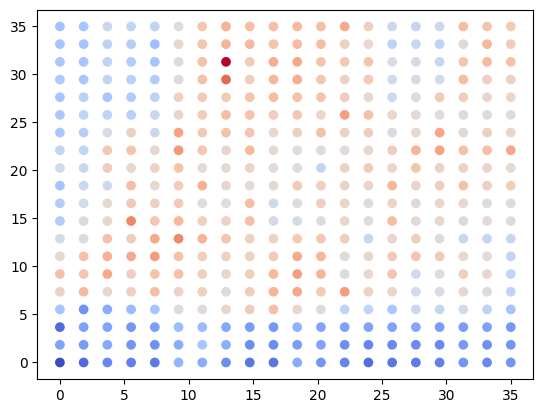

In [3]:
fig, ax = plt.subplots()
norm=PowerNorm(gamma=2.2)
cmap = "coolwarm"
ax.scatter(grid_comps[:,0], grid_comps[:,1], 
           c = z, 
           cmap = "coolwarm",
           norm = norm
           )
plt.show()

/Users/pozzolabadmin/Documents/codebase/envs/activephasemap/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


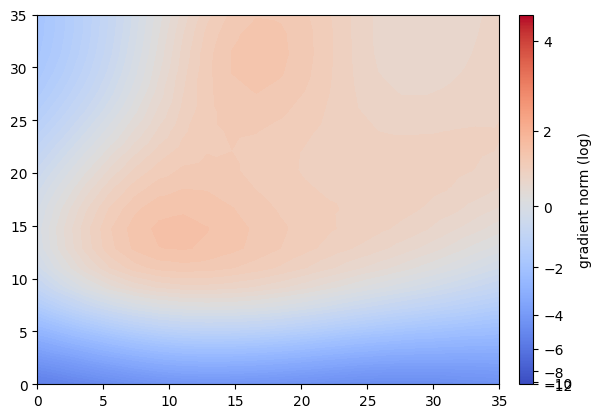

In [4]:
# Smoothen the phasemap gradient using a GP fit 

kernel = WhiteKernel() + ConstantKernel()*Matern()
gp = GaussianProcessRegressor(kernel=kernel, alpha=10.0, n_restarts_optimizer=10, )
# Fitting in the gp model
gp.fit(grid_comps, z)
z_pred = gp.predict(grid_comps)

fig, ax = plt.subplots()

ax.scatter(grid_comps[:,0], grid_comps[:,1], 
           c = z_pred, 
           cmap = "coolwarm",
           norm = norm
           )
ax.tricontourf(grid_comps[:,0],
                grid_comps[:,1], 
                z_pred,
                levels=50,
                cmap = cmap,
                norm = norm
                )
mappable = ScalarMappable(norm=norm, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.2)
cbar = fig.colorbar(mappable,shrink=0.5, aspect=5,cax=cax)
cbar.ax.set_ylabel('gradient norm (log)', rotation=90)
plt.savefig("./gp_smooth_phasemap.png")
plt.show()

In [ ]:
# def phasemap_gradient(xy):
#     """A function to compute gradient at any given composition.

#     xy : a tuple corresponding to a 2D composition.
#     """
#     global grads 
#     global num_fevals
#     c1, c2 = xy
#     comp = np.array([c1, c2]).reshape(1, 2)
#     out = gp.predict(comp)

#     print("Evaluated function for the %d-th time"%num_fevals, end="\r", flush=True)
#     num_fevals += 1

#     return out

# num_fevals = 0
# num_total_points = 48
# learner = adaptive.Learner2D(phasemap_gradient, design_space_bounds)
# adaptive.runner.simple(learner, npoints_goal = num_total_points)
# adaptive_samples_data = learner.to_numpy()
# np.random.shuffle(adaptive_samples_data)

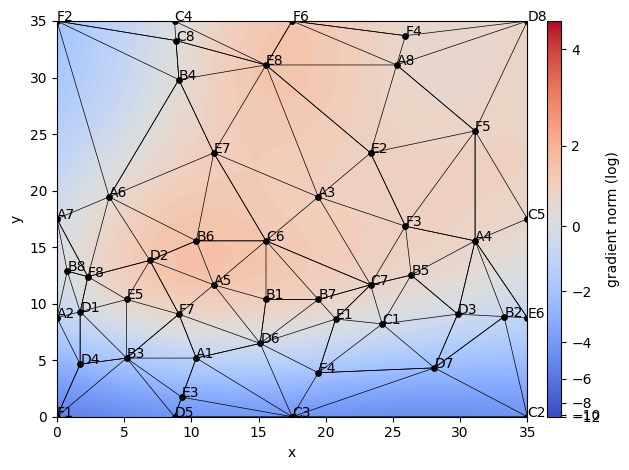

In [6]:
num_samples = adaptive_samples_data.shape[0]
tri = Delaunay(adaptive_samples_data[:,:2]) # the third column is function value

fig, ax = plt.subplots()
ax.tricontourf(grid_comps[:,0],
                grid_comps[:,1], 
                z_pred,
                levels=50,
                cmap = cmap,
                norm = norm
                )
mappable = ScalarMappable(norm=norm, cmap=cmap)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.2)
cbar = fig.colorbar(mappable,shrink=0.5, aspect=5,cax=cax)
cbar.ax.set_ylabel('gradient norm (log)', rotation=90)

for simplex in tri.simplices:
    pts = tri.points[simplex]
    ax.plot(pts[:, 0], pts[:, 1], 'k-', lw=0.5)
ax.scatter(adaptive_samples_data[:,0], 
           adaptive_samples_data[:,1], 
           s=15, 
           color="k",
           zorder=2
           )
for i in range(num_total_points):
    q, r = divmod(i, 8)
    well_rows = ["A", "B", "C", "D", "E", "F"]
    label = "%s%d"%(well_rows[q],r+1)
    ax.text(adaptive_samples_data[i,0], 
            adaptive_samples_data[i,1], 
            label
            )
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.tight_layout()
plt.show()

### Convert 96-wp volumes into 48-wp and prepare full CSV file

In [7]:
factor = 1300/300
CTAB = factor*96
GCH = factor*59
GS = factor*24 
comps = factor*adaptive_samples_data[:,:2]
n_samples = len(comps)
SN = np.round(comps[:,0].reshape(-1,1))
AA = np.round(comps[:,1].reshape(-1,1))
CTAB_ = np.array([CTAB]*n_samples).reshape(-1,1)
GCH_ = np.array([GCH]*n_samples).reshape(-1,1)
GS = np.array([GS]*n_samples).reshape(-1,1)

volumes = np.hstack((CTAB_, GCH_, AA, SN, GS))
WATER = 1300 - np.sum(volumes, axis=1).reshape(-1,1)
volumes_ = np.hstack((CTAB_, WATER, GCH_, AA, SN, GS)).round().astype(int)
volume_df_48 = pd.DataFrame(volumes_, columns=['CTAB', 'Water', 'GCH', 'AA', 'SN', 'GS'])
volume_df_48

,CTAB,Water,GCH,AA,SN,GS
0,416,457,256,22,45,104
1,416,486,256,38,0,104
2,416,356,256,84,84,104
3,416,322,256,67,135,104
4,416,422,256,51,51,104
5,416,423,256,84,17,104
6,416,448,256,76,0,104
7,416,279,256,135,110,104
8,416,412,256,45,67,104
9,416,342,256,38,144,104


In [9]:
volume_df_48 = pd.read_csv("./saxs_48_adaptive.csv")
volume_df_48

,CTAB,Water,GCH,AA,SN,GS
0,416,457,256,22,45,104
1,416,486,256,38,0,104
2,416,356,256,84,84,104
3,416,322,256,67,135,104
4,416,422,256,51,51,104
5,416,423,256,84,17,104
6,416,448,256,76,0,104
7,416,279,256,135,110,104
8,416,412,256,45,67,104
9,416,342,256,38,144,104


## Synthesis of first batch on 05/08/2025 

In order to simplify the timeline of synthesis and align this with a likely longer run of SAXS (20hrs in total), we are only going to synthesize the first 20 samples from the above list. 
The list of samples are randomized in a way that they span various regions in the design space and are a subset of the adaptive samples shown above. 

In [8]:
volume_df_050825 = pd.read_csv("./saxs_050825.csv")
volume_df_050825

,CTAB,Water,GCH,AA,SN,GS
0,416,460,256,54,10,104
1,416,372,256,101,51,104
2,416,356,256,84,84,104
3,416,397,256,37,90,104
4,416,356,256,54,114,104
5,416,383,256,36,105,104
6,416,356,256,39,129,104
7,416,279,256,135,110,104
8,416,446,256,39,39,104
9,416,372,256,152,0,104


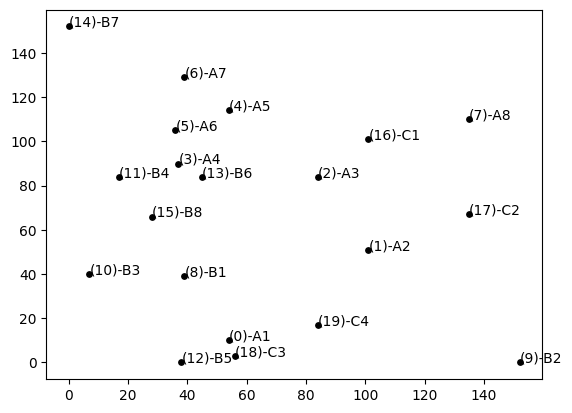

In [10]:
fig, ax = plt.subplots()
ax.scatter(volume_df_050825["AA"], 
           volume_df_050825["SN"], 
           s=15, 
           color="k",
           zorder=2
           )
for i in range(volume_df_050825.shape[0]):
    q, r = divmod(i, 8)
    well_rows = ["A", "B", "C", "D", "E", "F"]
    label = "(%d)-%s%d"%(i, well_rows[q],r+1)
    ax.text(volume_df_050825["AA"][i], 
            volume_df_050825["SN"][i], 
            label
            )
plt.show()

When we run SAXS, we will take measurement of empty capillary, water, and 3 samples in the design space as a trial run. 
The three samples here are chosen as : 14, 12, 2.

All the samples would be centrifuged and the particles drawn from the bottom of the well would be used for SAXS. 

In [11]:
volume_df_050825.sum(axis=0)

CTAB     8320
Water    7892
GCH      5120
AA       1242
SN       1346
GS       2080
dtype: int64

## Samples for SAXS on 05/21/25

In [ ]:
# from scipy.spatial import distance

# comps_previous = volume_df_050825[["AA", "SN"]].to_numpy()

# not_sampeld_inds = []
# for i, sample in volume_df_48.iterrows():
#     comps = sample[["AA", "SN"]].to_numpy().reshape(1,2)
#     dists = distance.cdist(comps, comps_previous, 'euclidean')
#     if not (dists==0).any():
#         not_sampeld_inds.append(i)

# volume_df_052125 = volume_df_48.iloc[np.asarray(not_sampeld_inds), :].reset_index()
# volume_df_052125.sum()


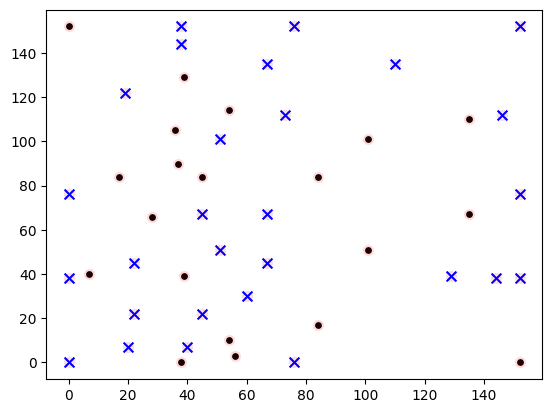

In [ ]:
# fig, ax = plt.subplots()
# ax.scatter(volume_df_050825["AA"], 
#            volume_df_050825["SN"], 
#            s=15, 
#            color="k",
#            )
# ax.scatter(volume_df_48["AA"], 
#            volume_df_48["SN"], 
#            s=50, 
#            color="r",
#            alpha=0.1
#            )
# ax.scatter(volume_df_48["AA"][np.asarray(not_sampeld_inds)], 
#            volume_df_48["SN"][np.asarray(not_sampeld_inds)], 
#            s=50, 
#            color="b",
#            marker='x',
#            )
# plt.show()

In [7]:
volume_df_052125 = pd.read_csv("./saxs_052125.csv")
volume_df_052125

,index,CTAB,Water,GCH,AA,SN,GS
0,0,416,457,256,22,45,104
1,3,416,322,256,67,135,104
2,4,416,422,256,51,51,104
3,6,416,448,256,76,0,104
4,8,416,412,256,45,67,104
5,9,416,342,256,38,144,104
6,10,416,480,256,22,22,104
7,11,416,356,256,129,39,104
8,13,416,412,256,67,45,104
9,18,416,448,256,0,76,104


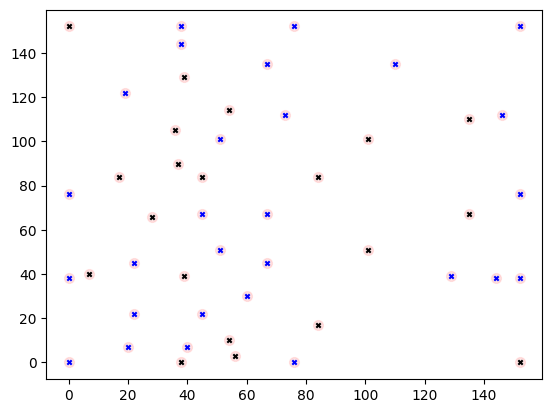

In [13]:
fig, ax = plt.subplots()
ax.scatter(volume_df_48["AA"], 
           volume_df_48["SN"], 
           s=50, 
           color="r",
           alpha=0.1
           )
ax.scatter(volume_df_052125["AA"], 
           volume_df_052125["SN"], 
           s=10, 
           color="b",
           marker='x',
           )
ax.scatter(volume_df_050825["AA"], 
           volume_df_050825["SN"], 
           s=10, 
           color="k",
           marker='x',
           )
plt.show()